In [1]:
pip install python-mnist==0.5 # 다운받은 data 불러오는 라이브러리

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for python-mnist: filename=python_mnist-0.5-py3-none-any.whl size=11114 sha256=219cf5c4060462e5b7c13e1f21c751b1c8205f6e8a5f84a45fd5d2de8c6dfd06
  Stored in directory: /root/.cache/pip/wheels/67/d1/46/43124d12260cf439a101157c358c8c2df565fd1744fa81a742
Successfully built python-mnist


In [2]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

import random

from mnist import MNIST

import torch.utils.data as data_utils
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [3]:
device  = 'cuda' if torch.cuda.is_available else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)

if device=='cuda':
  torch.cuda.manual_seed_all(777)

cuda


# Load Dataset and Preprocessing

In [4]:
mnist = MNIST("/content/drive/MyDrive/Colab Notebooks/data/raw")

x_train, y_train = mnist.load_training()
x_test, y_test = mnist.load_testing()

# data는 list 형식으로 되어 있으므로 shape를 보고, 이미지 visualization를 하기 편한 array 형태로 바꾸어줌

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

print("x_train의 shape={}, y_train의 shape={}".format(x_train.shape, y_train.shape))
print("x_test의 shape={}, y_test의 shape={}".format(x_test.shape, y_test.shape))

x_train의 shape=(60000, 784), y_train의 shape=(60000,)
x_test의 shape=(10000, 784), y_test의 shape=(10000,)


# Convert array data into Tensor Dataset

1. array 형태의 x와 y data를 TensorDataset 형태로 train_data에 담기
2. 하나로 묶어준 x tensor, y tensor data를 batch 단위로 나누어서 trainloader에 담아주기


In [5]:
train_data = data_utils.TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(torch.FloatTensor(y_train)))

batch_size = 1000
trainloader = data_utils.DataLoader(train_data, batch_size=batch_size, shuffle=True)

tensor(0.)


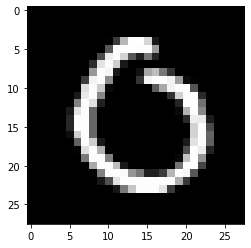

In [6]:
for batch_idx, (image, label) in enumerate(trainloader):
    plt.imshow(image[0].reshape(28,28), cmap = 'gray')
    print(label[0])
    break

## Define Linear Model using with ReLU

### Use Forward Function 

In [7]:
class Adam_Model(nn.Module):
    def __init__(self):
        super(Adam_Model, self).__init__()
        
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,10)
        
    def forward(self, x): # 만들어준 네트워크의 핵심적이 부분 # x: input data
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        class_label = self.fc3(h2)
        
        return class_label       

In [8]:
model = Adam_Model().to(device)

In [9]:
model

Adam_Model(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

# Dummy Data

CNN => Con => Kernel, stride, padding => outputshape

In [10]:
a = torch.Tensor(1, 784).to(device)

In [11]:
a.shape

torch.Size([1, 784])

In [12]:
model(a).shape

torch.Size([1, 10])

- output이 10개인 것을 확인함으로써 모델이 잘 생성된 것을 알 수 있음

# Set Parameteres

In [13]:
epoch = 15
learning_rate = 0.01
weight_decay = 1e-5

# Define Loss Function & Define Optimizer

In [14]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Train

In [15]:
loss_list = []

for epoch_num in range(epoch):
  
  average_loss = 0

  for batch_idx, (x_data, y_label) in enumerate(trainloader):

    num_of_mini_batch = len(trainloader)

    images = x_data.to(device)
    labels = y_label.to(device)

    optimizer.zero_grad()

    predict = model(images)

    y_label_long = torch.tensor(labels, dtype = torch.long)
    y_label_long = y_label_long.to(device)

    loss = loss_function(predict, y_label_long)

    loss.backward()
    optimizer.step()

    average_loss += (loss.item()/num_of_mini_batch)

    loss_list.append(loss.item())

  print("epoch {}의 평균 loss 값은 => {:.5f}".format((epoch_num+1), average_loss))

epoch 1의 평균 loss 값은 => 10.28413
epoch 2의 평균 loss 값은 => 1.09126
epoch 3의 평균 loss 값은 => 0.65310
epoch 4의 평균 loss 값은 => 0.38670
epoch 5의 평균 loss 값은 => 0.31959
epoch 6의 평균 loss 값은 => 0.27771
epoch 7의 평균 loss 값은 => 0.25066
epoch 8의 평균 loss 값은 => 0.23789
epoch 9의 평균 loss 값은 => 0.21760
epoch 10의 평균 loss 값은 => 0.22559
epoch 11의 평균 loss 값은 => 0.19990
epoch 12의 평균 loss 값은 => 0.18867
epoch 13의 평균 loss 값은 => 0.17549
epoch 14의 평균 loss 값은 => 0.16684
epoch 15의 평균 loss 값은 => 0.16713


In [16]:
# 60000개를 1000 배치로 나누었을때 60이 되므로 epoch 하나당 60 묶음의 배치가 학습이된다
# 15 epoch 이므로 900 묶음의 배치가 학습이 되게 되고 list 에 append 되는 loss value 도 900 개가 된다.
print("loss_list의 길이 =",len(loss_list))

loss_list의 길이 = 900


## 2번째 epoch의 loss 값을 한 번 확인

In [17]:
epoch_loss = 0
for i in range(60):
  epoch_loss = epoch_loss + loss_list[i+60]

print(epoch_loss/60)

1.091262423992157


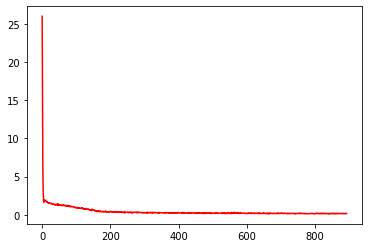

In [18]:
plt.plot(np.array(loss_list[7:]), 'r')

In [19]:
import pickle

# wb - 바이트 형식으로 저장

with open('ADAM.pickle', 'wb') as f:
    pickle.dump(loss_list, f)

# Test

In [20]:
test_data = data_utils.TensorDataset(torch.FloatTensor(x_test), torch.FloatTensor(y_test))

testloader = data_utils.DataLoader(test_data, batch_size=5000, shuffle=False)

In [21]:
with torch.no_grad():
  num_total_data = 0
  correct = 0

  for batch_idx, (images, labels) in enumerate(testloader):
    
    images = images.to(device)
    labels = labels.to(device)

    output = model(images)

    output_softmax = torch.nn.functional.softmax(output)
    predicted = torch.argmax(output_softmax, dim=1)

    num_total_data += len(images)

    answer = sum(labels == predicted).item()

    correct += answer

  print("Adam을 사용한 model의 accuracy는 %.2f%%"%((correct/num_total_data)*100))

Adam을 사용한 model의 accuracy는 94.36%
